## Import Libraries & Load Dataset¶

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [19]:
path_train = "/content/dataset/train/"
path_val = "/content/dataset/val/"
epochs = 20
lr = 0.001
batch_size = 1

## Super Resolution Dataset

In [20]:
def read_dataset(path):
  low_img = []
  high_img = []
  for files in os.listdir(path):
    dir = os.path.join(path,files)
    for img in os.listdir(os.path.join(path,files)):
      img = cv2.imread(os.path.join(dir,img))
      img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      img = img / 255.0
      if files=="high_res": high_img.append(img)
      else: low_img.append(img)
  
  return np.array(high_img), np.array(low_img)

In [21]:
high_train , low_train = read_dataset(path_train)
high_val , low_val = read_dataset(path_val)

In [24]:
def downsample(filters, size, apply_batchnorm=True):
  result = Sequential()
  result.add(layers.Conv2D(filters, size, strides=2, padding="same"))
  if apply_batchnorm:
    result.add(layers.BatchNormalization())
  result.add(layers.LeakyReLU())
  return result

In [25]:
def upsample(filters, size):
  result = Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2, padding="same"))
  result.add(layers.BatchNormalization())
  result.add(layers.LeakyReLU())
  return result

## Autoencoder Model

In [26]:
def autoencoder():
  # Encoder
  inputs = layers.Input([256,256,3])
  downsample1 = downsample(128,3,False)(inputs)
  downsample2 = downsample(128,3,True)(downsample1)
  downsample3 = downsample(256,3,True)(downsample2)
  downsample4 = downsample(256,3,True)(downsample3)
  downsample5 = downsample(512,3,True)(downsample4)
  downsample6 = downsample(512,3,True)(downsample5)
  
  #Decoder
  upsample1 = upsample(512,3)(downsample6)
  skip1 = layers.concatenate([upsample1,downsample5])
  upsample2 = upsample(256,3)(skip1)
  skip2 = layers.concatenate([upsample2,downsample4])
  upsample3 = upsample(256,3)(skip2)
  skip3 = layers.concatenate([upsample3,downsample3])
  upsample4 = upsample(128,3)(skip3)
  skip4 = layers.concatenate([upsample4,downsample2])
  upsample5 = upsample(128,3)(skip4)
  skip5 = layers.concatenate([upsample5,downsample1])
  upsample6 = upsample(3,3)(skip5)
  skip6 = layers.concatenate([upsample6,inputs])
  output = layers.Conv2D(3,(2,2),strides=1,padding="same")(skip6)


  return Model(inputs,output)

In [27]:
model = autoencoder()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_12 (Sequential)     (None, 128, 128, 12  3584        ['input_2[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_13 (Sequential)     (None, 64, 64, 128)  148096      ['sequential_12[0][0]']          
                                                                                            

In [28]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5",monitor="val_loss",mode="min",save_best_only=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),loss="mse")

In [29]:
model.fit(low_train,high_train,
          epochs=epochs,
          batch_size=batch_size,
          validation_data=(low_val,high_val),
          callbacks=[checkpoint])

Epoch 1/20
685/685 [==============================] - 21s 28ms/step - loss: 0.0149 - val_loss: 0.0055
Epoch 2/20
685/685 [==============================] - 18s 26ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 3/20
685/685 [==============================] - 18s 26ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 4/20
685/685 [==============================] - 17s 25ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 5/20
685/685 [==============================] - 18s 26ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/20
685/685 [==============================] - 18s 26ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/20
685/685 [==============================] - 18s 26ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/20
685/685 [==============================] - 17s 25ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/20
685/685 [==============================] - 17s 25ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/20
685/685 [==============================] - 17s 26ms/step - loss: 9.885

## Display Images

In [30]:
def display_image(num):
  for i in range(num):
    plt.figure(figsize=(24,15))
    plt.subplot(1,3,1)
    plt.imshow(low_val[i])
    plt.title("LOW_IMAGE")
    plt.axis("off")
    plt.subplot(1,3,2)
    plt.imshow(high_val[i])
    plt.title("HIGH_IMAGE")
    plt.axis("off")
    plt.subplot(1,3,3)
    plt.imshow(model.predict(np.expand_dims(low_val[i],axis=0))[0])
    plt.title("PREDICT_IMAGE")
    plt.axis("off")
    plt.show()

1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


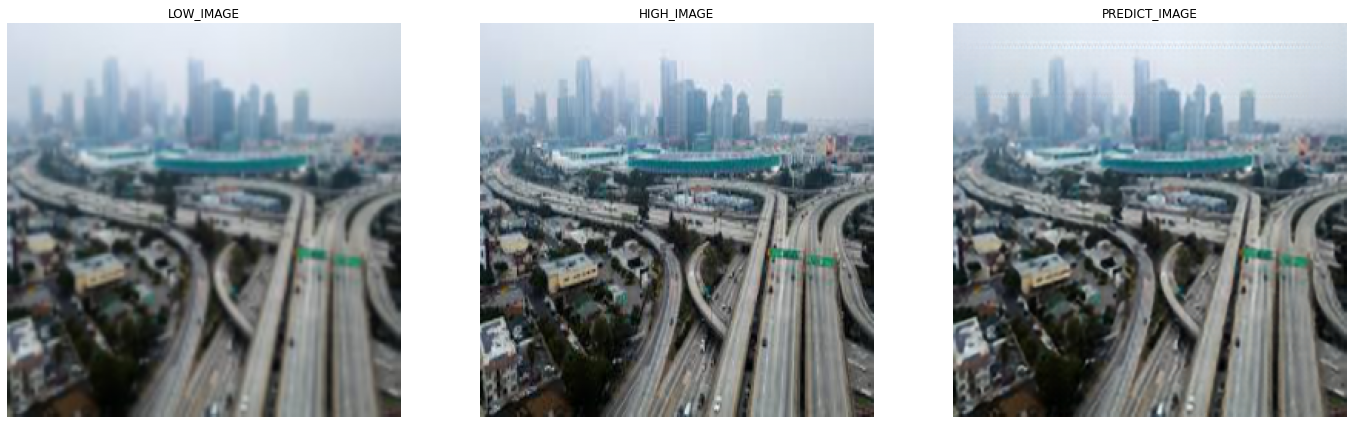

In [31]:
display_image(5)